In [1]:
from scipy.stats import chisquare
from scipy.stats import geom, uniform
import matplotlib.pyplot as plt
import numpy as np
cmap = plt.get_cmap("tab10").colors
from collections import Counter

### Проверим корректность критерия хи-квадрат из scipy.stats

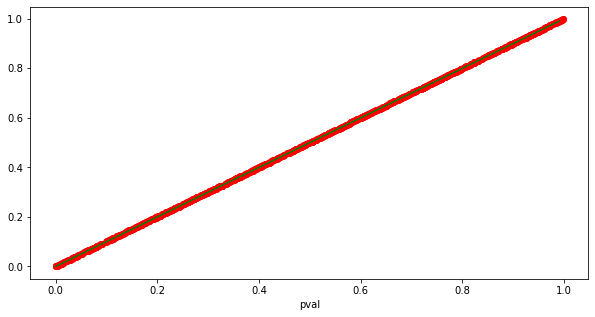

In [37]:
ans = []
for _ in range(1000):
    tmp = np.random.uniform(0, 1, 1000)
    tmp = [sum(tmp<i) for i in np.arange(0.1, 1.1, 0.1)]
    for i in range(9, 0, -1):
        tmp[i] -= tmp[i-1]
    
    ans.append(chisquare(tmp)[1])
    
xs = np.arange(0, 1, 0.01)
    
plt.figure(figsize=(10, 5))
plt.scatter(ans, ans, c='r')
plt.plot(xs, xs, c = 'g')
plt.xlabel('pval')
plt.show()

При верной нулевой гипотезе p-value распределено равномерно

Критерий согласия хи-квадрат реализован в scipy в виде функции scipy.stats.chisquare. Чтобы избежать проблем с маленькими ожидаемыми частотами предлагается разбить все значения на интервалы по квантилям. Тогда в каждом интервале будет находиться одинаковое число значений.

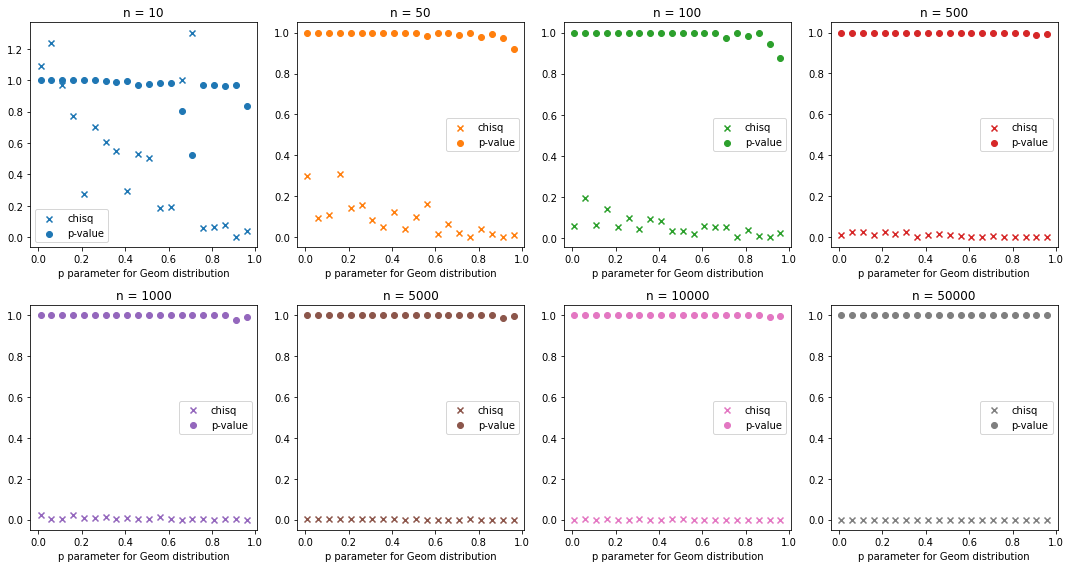

In [76]:
plt.figure(figsize=(15, 8))

for k, i in enumerate([10, 50, 100, 500, 1000, 5000, 10000, 50000]):
    pp = np.arange(0.01, 1, 0.05)
    chi = []
    pvals = []
    for p in pp:
        xs = geom.rvs(p, size=i)
        ends = np.unique(np.array(geom.ppf(q=np.arange(0.01, 1.01, 0.1), p=p), dtype=int))
        
        obs = [(xs<=ends[0]).sum()] + [((ends[i] < xs) & (xs <= ends[i+1])).sum() for i in range(len(ends)-1)] + [(ends[-1]<xs).sum()]
        obs = np.array(obs) / i
        
        exp = geom.cdf(k=ends, p=p)
        exp = list(reversed([1-exp[-1]] + [exp[i] - exp[i-1] for i in range(len(exp)-1, 0, -1)] + [exp[0]]))
        
        chisq, p = chisquare(obs, f_exp=exp)
        chi.append(chisq)
        pvals.append(p)
        

    plt.subplot(2, 4, k+1)
    plt.tight_layout()
    plt.scatter(pp, chi, marker="x", label="chisq", color=cmap[k])
    plt.scatter(pp, pvals, marker="o", label="p-value", color=cmap[k])
    plt.xlabel("p parameter for Geom distribution")
    plt.title("n = " + str(i))
    plt.legend()
    
plt.show()

Значение p-value получаются всегда большие вне зависимости от значения параметра распределения p и количества образцов. Нет оснований отвергнуть нулевую гипотезу.

#### Проверим мощность критерия для различных простых альтернативных гипотез

$H_0: p=p_0 ~~~H_1: p=p_1$

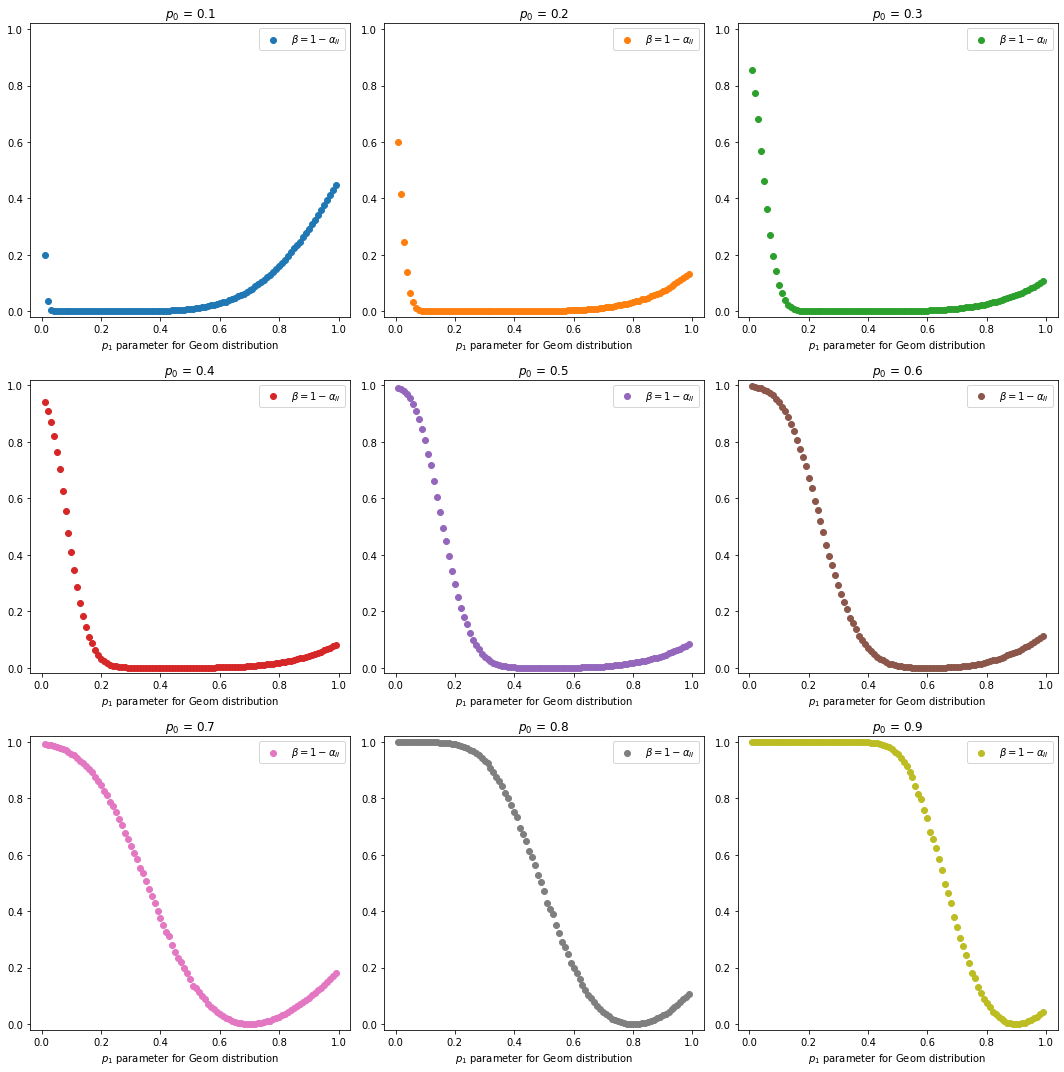

In [100]:
plt.figure(figsize=(15, 15))

i = 100000 # n samples

for k, p in enumerate([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]):
    pp = np.arange(0.01, 1, 0.01)
    chi = []
    pvals = []
    for p_1 in pp:
        xs = geom.rvs(p_1, size=i)
        
        ends = np.unique(np.array(geom.ppf(q=np.arange(0.01, 1.01, 0.1), p=p), dtype=int))
        
        obs = [(xs<=ends[0]).sum()] + [((ends[i] < xs) & (xs <= ends[i+1])).sum() for i in range(len(ends)-1)] + [(ends[-1]<xs).sum()]
        obs = np.array(obs) / i
        
        exp = geom.cdf(k=ends, p=p)
        exp = list(reversed([1-exp[-1]] + [exp[i] - exp[i-1] for i in range(len(exp)-1, 0, -1)] + [exp[0]]))
        
        chisq, pv = chisquare(obs, f_exp=exp)
        chi.append(chisq)
        pvals.append(1-pv)
        

    plt.subplot(3, 3, k+1)
    plt.tight_layout()
    #plt.scatter(pp, chi, marker="x", label="chisq", color=cmap[k])
    plt.scatter(pp, pvals, marker="o", label="$\\beta=1-\\alpha_{II}$", color=cmap[k])
    plt.xlabel("$p_1$ parameter for Geom distribution")
    plt.ylim(-0.02, 1.02)
    plt.title("$p_0$ = " + str(p))
    plt.legend()
    
plt.show()

Для простой альтернативной гипотезы мощность зависит от выбора параметра альтернативной гипотезы. Чем сильнее различаются параметры нулевой и альтернативной гипотезы, тем мощнее критерий.